# CNN 

In [1]:
# for numbers
import numpy as np
import pandas as pd
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# for PCA
from sklearn.decomposition import PCA
# for split the data on train and test
from sklearn.model_selection import train_test_split

# all for the model
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

path = '../input/chinese-mnist-digit-recognizer/chineseMNIST.csv'

In [2]:
# Read the dataset
ds = pd.read_csv(path)
print(ds.shape)
ds.head()

(15000, 4098)


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


In [3]:
# the labels and the character cols
labels_cols = ['label', 'character']
# select only the images
data = ds.drop(labels_cols, axis=1).values
# select the labels and the characters
labels = ds[labels_cols[0]].values
characters = ds[labels_cols[1]].values

data.shape, labels.shape, characters.shape

((15000, 4096), (15000,), (15000,))

#  Processing 

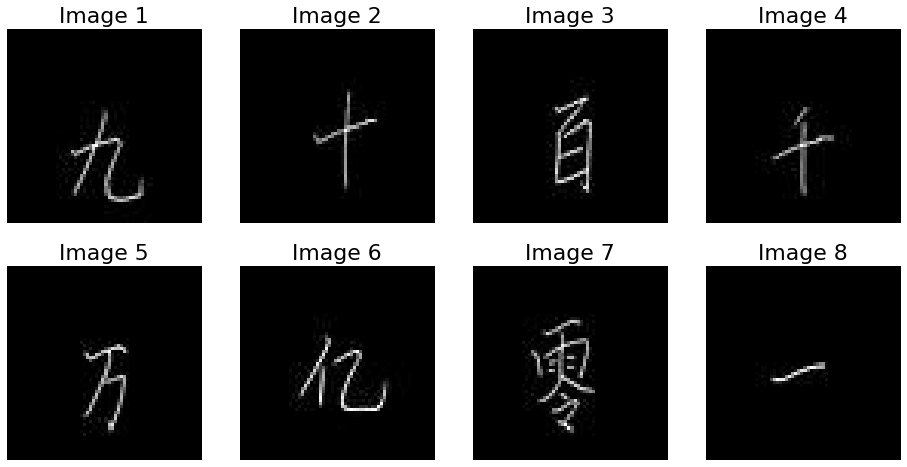

In [4]:
# to process the data and convert to 64x64 images
# receives data
def process_data(x):
    images = [] # all the images
    # is each row in x, each image
    for img in x:
        # reshape the flatten data
        image = img.reshape(64,64,1)
        images.append(image)
    # return the images in an apropiate format
    return np.array(images).astype('float32')/255

# recieves labels
def process_target(chars, num_classes):
    target = [] # is the result
    class_names = {} # other result
    count = count_values(chars) # count the characters
    ###### add the labels for the dict
    for key, i in zip(count.keys(), range(num_classes)):
        class_names[key] = i
    ###### create the labels data, the numbers
    labs = class_names.keys()
    for char in chars:
        pos = class_names[char] # position of the 1
        row = []
        for i in range(num_classes):# create the target [0,0,0...,1,...]
            if pos != i:
                row.append(0)
            else:
                row.append(1)
        target.append(row)
    return np.array(target).astype('float32'), class_names


def count_values(arr):
    dic = {}
    for val in arr:
        if val not in dic.keys():
            dic[val] = 1
        else:
            dic[val] += 1
    return dic

# plot multiple images, preds is for the titles
# preds must be like [[real, pred]]
def plot_images(imgs, dims, figsize, title_size, preds=[]):
    plt.figure(figsize=figsize)
    for img, i, in zip(imgs, np.arange(imgs.shape[0])):
        plt.subplot(dims[0], dims[1], i+1)
        plt.imshow(np.squeeze(img), cmap='gray')
        plt.axis('off')
        title = f'Image {i+1}'
        if preds != []:
            title = f'Real: {preds[i][0]}, Pred: {preds[i][1]}'
        plt.title(title, fontsize=title_size)
    plt.show()
    
# these numbers are just to prove*
sample_data = process_data(data[:8008:1001])
plot_images(sample_data, dims=(2,4), figsize=(16,8), title_size=22)

In [5]:
# get the images from the df as arrays
X = process_data(data)

# and obtain the target data from the characters
Y, class_names = process_target(characters, num_classes=15)

X.shape, X.dtype, Y.shape, Y.dtype

((15000, 64, 64, 1), dtype('float32'), (15000, 15), dtype('float32'))

# Split the Data on train and test

In [6]:
# split the dataset in train and test. validation set will be included in the training, later
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=.1, random_state=314, shuffle=True
)

x_train.shape, x_test.shape

((13500, 64, 64, 1), (1500, 64, 64, 1))

#  CNN model

In [8]:
# to reset the keras session
#keras.backend.clear_session()

input_shape = (64,64,1) # the dimension of the data
num_classes = 15 # the number of classes

cnn = Sequential([
    # define the input shape with a layer
    layers.InputLayer(input_shape=input_shape),

    # convolutional part with relu and later pooling
    layers.Conv2D(filters=32, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    # flatten the data, as it comes with (64,64,1) shape
    layers.Flatten(),
    
    # dense part, with neurons
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=.3), # turn off random neurons in each step
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=.3), # it helps to prevent overfitting
    layers.Dense(num_classes, activation='softmax')
])

# the last layer has multiple (15) neurons since the result we
# want looks like the one in the cell above, each neuron provides
# one of these numbers

cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy'],
)

In [16]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               7373056   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

## Train the cnn

In [9]:
# as the model performance increases faster
# it might be good to use an early stopping

early_stopping = EarlyStopping(
    min_delta=.005, # minimum performance increase
    patience=10, # epochs until the stop
    restore_best_weights=True
)

cnn_hist = cnn.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=40,
    validation_split=.1,# as there's no val data
    callbacks=[early_stopping]
)

Epoch 1/40
190/190 [==============================] - 26s 131ms/step - loss: 1.9789 - accuracy: 0.3583 - val_loss: 0.6600 - val_accuracy: 0.7859
Epoch 2/40
190/190 [==============================] - 24s 127ms/step - loss: 0.6556 - accuracy: 0.7805 - val_loss: 0.3638 - val_accuracy: 0.8815
Epoch 3/40
190/190 [==============================] - 24s 129ms/step - loss: 0.3801 - accuracy: 0.8701 - val_loss: 0.2813 - val_accuracy: 0.9074
Epoch 4/40
190/190 [==============================] - 24s 128ms/step - loss: 0.2519 - accuracy: 0.9141 - val_loss: 0.2371 - val_accuracy: 0.9281
Epoch 5/40
190/190 [==============================] - 24s 127ms/step - loss: 0.1760 - accuracy: 0.9436 - val_loss: 0.1990 - val_accuracy: 0.9393
Epoch 6/40
190/190 [==============================] - 25s 130ms/step - loss: 0.1392 - accuracy: 0.9490 - val_loss: 0.2321 - val_accuracy: 0.9296
Epoch 7/40
190/190 [==============================] - 25s 133ms/step - loss: 0.1057 - accuracy: 0.9635 - val_loss: 0.1757 - val_ac

#   results

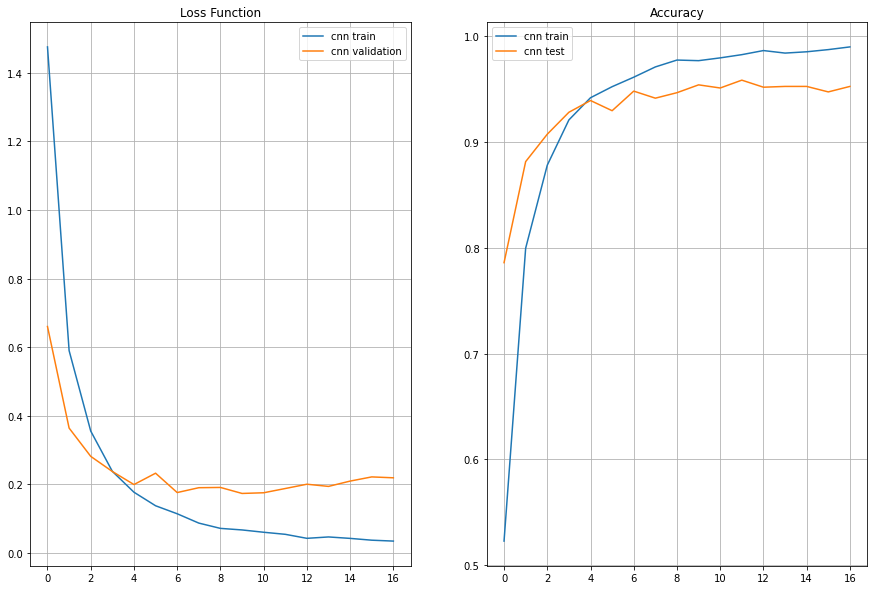

In [13]:
plt.figure(figsize=(15, 10))

# plot the loss function
plt.subplot(1,2,1)
# loss functions
plt.plot(cnn_hist.history['loss'], label='cnn train')
plt.plot(cnn_hist.history['val_loss'], label='cnn validation')
plt.title('Loss Function')
plt.grid(True)
plt.legend()

# and the accuracy
plt.subplot(1,2,2)
plt.plot(cnn_hist.history['accuracy'], label='cnn train')
plt.plot(cnn_hist.history['val_accuracy'], label='cnn test')
plt.grid(True)
plt.title('Accuracy')
plt.legend()

plt.show()

In [14]:
cnn_results = cnn.evaluate(x_test, y_test, batch_size=64);

print('=> CNN Results')
print("test loss, test acc:", cnn_results)


24/24 [==============================] - 1s 38ms/step - loss: 0.1635 - accuracy: 0.9540
=> CNN Results
test loss, test acc: [0.16351771354675293, 0.9539999961853027]

=> NN Results
